# DynamicNets.jl


The code has been developed in Julia 1.4.0 version, as a code accompanying the Barunik and Ellington (2020) papers, and provides an estimation and inference for *dynamic networks* measures introduced in the following papers

Baruník, J. and Ellington, M. (2020): *Dynamic Networks in Large Financial and Economic Systems*, manuscript [available here for download](https://ideas.repec.org/p/arx/papers/2007.07842.html) (July 2020)

Baruník, J. and Ellington, M. (2020): *Dynamic Network Risk*, manuscript [available here for download](https://ideas.repec.org/p/arx/papers/2006.04639.html) (Jun 2020)


## Software requirements

[Julia](http://julialang.org/) together with few packages needs to be installed

````julia
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Statistics")
Pkg.add("LinearAlgebra")
Pkg.add("Distributions")
Pkg.add("Plots")
````

# Example of usage
## Time Dynamics of Network Connectedness

This example illustrates how to obtain various dynamic network measures on an example data consising of 4 variable system

NOTE that computation time is growing with number of variables in the system and simulations used to obtain measures. This readme file also includes usage of parallel computing that can help to increase the speed of computations tremendously.

Note the full example is available as an interactive [IJulia](https://github.com/JuliaLang/IJulia.jl) notebook [here](https://github.com/barunik/DynamicNets.jl/blob/master/readme.ipynb)


Load required packages

In [1]:
using Pkg
Pkg.activate(".") # activating project in its directory
Pkg.instantiate() # installing packages with which versions the project is built

 Activating environment at `~/GitHub/DynamicNets.jl/Project.toml`


In [3]:
using CSV
using DataFrames
using Distributions
using LinearAlgebra
using Statistics
using Plots

In [4]:
# load main functions
include("DynamicNets_functions.jl");

Load example data

In [5]:
data = CSV.read("exampledata.txt", DataFrame, header=false)
data = convert(Matrix{Float64}, data[:,1:4]);
data = sqrt.(data);

Function DynNet_time estimates time varying total network connectedness as well as directional connectedness with following inputs and outputs, timing for a 4 variable system and 100 simulations is for MacBook Pro 2020 with 2,3 GHz Quad-Core Intel Core i7 with 32GB 3733 MHz Memory. Note julia compiles functions at the first run so the second run times will be much faster

````julia
C, CI1, CI2 = DynNet_time(data,L,H,W,Nsim,corr)

# INPUTS: L = 2,       number of lags in VAR
#          H=10,       horizons in the FEVD
#          W = 8,       width of kernel bandwidth
#          Nsim = 100,  number of simulations 
#          corr = true, true = diagonal covariance matrix of errors
#                       false = estimated covariance matrix of errors
#
# OUTPUTS:  C           median estimates of Network Connectedness
#                       C has [ ( 1+5xN ) x T ] dimension with N number of variables in the system
#           CI1, CI2    2.5% and 97.5% quantiles of all C measures
#                       CI1 and CI2 has [ ( 1+5xN ) x T ] dimension with N number of variables in the system
# OUTPUT ROWs:
#          1 is Total network connectedness
#          2+0xN...1xN+1 is net TO network connectedness for all N variables
#          2+1xN...2xN+1 is net FROM network connectedness for all N variables
#          2+2xN...3xN+1 is net FROM network connectedness normalised by own shock for all N variables
#          2+3xN...4xN+1 is net TO network connectedness normalised by own shock for all N variables
#          2+4xN...5xN+1 is net directional (difference) network connectedness for all N variables
````

In [6]:
@time C, CI1, CI2 = DynNet_time(data, 2, 10, 8, 100, false);

 81.756911 seconds (94.54 M allocations: 71.179 GiB, 9.65% gc time)


Dimension of the estimated measures is always [ ( 1+5xN ) x T ], for N=4 variables and T=1832 time periods, it is

In [7]:
size(C)

(21, 1832)

The first row of C and CI is holding total dynamic network connectedness meadian and stadard deviation

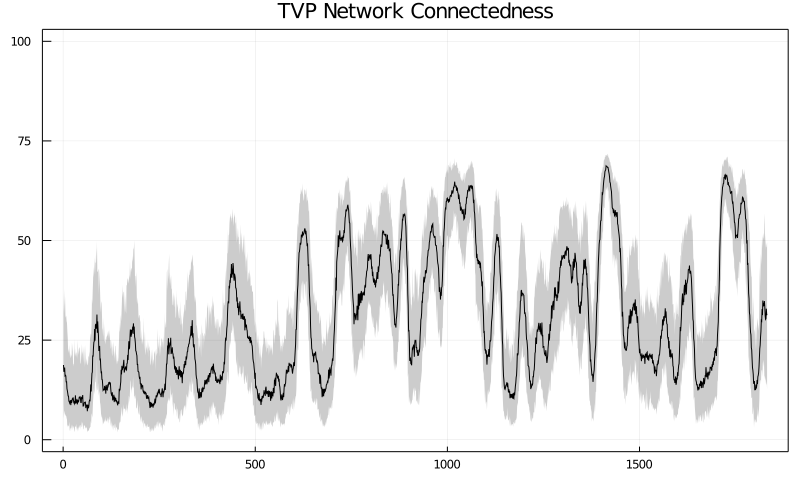

In [8]:
plot(C[1,:],ribbon=(C[1,:]-CI1[1,:],CI2[1,:]-C[1,:]),fillalpha=0.2,color=["black" "grey" "grey"],legend=false,ylim=[0,100],framestyle = :box, size=(800,480), title="TVP Network Connectedness")

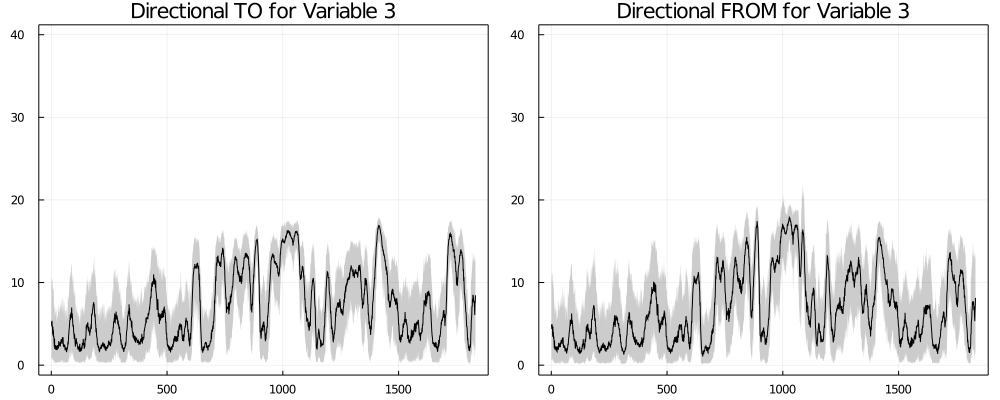

In [9]:
i=3

plot(plot(C[i+1,:],ribbon=(C[i+1,:]-CI1[i+1,:],CI2[i+1,:]-C[i+1,:]),fillalpha=0.2,color=["black" "grey" "grey"],legend=false,ylim=[0,40],framestyle = :box,
    size=(400,400),title="Directional TO for Variable 3"),
    plot(C[2+1*4+i-1,:],ribbon=(C[2+1*4+i-1,:]-CI1[2+1*4+i-1,:],CI2[2+1*4+i-1,:]-C[2+1*4+i-1,:]),fillalpha=0.2,color=["black" "grey" "grey"],legend=false,ylim=[0,40],framestyle = :box,
    size=(400,400),title="Directional FROM for Variable 3"),
size=(1000,400))

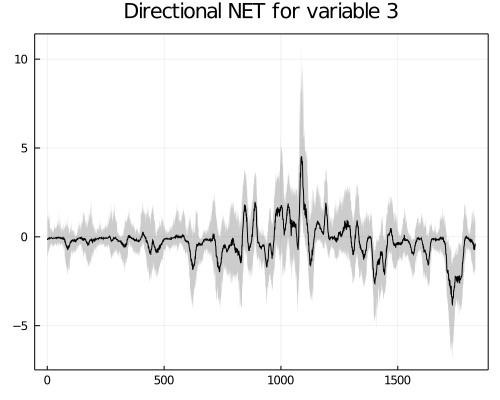

In [10]:
plot(C[2+4*4+i-1,:],ribbon=(C[2+4*4+i-1,:]-CI1[2+4*4+i-1,:],CI2[2+4*4+i-1,:]-C[2+4*4+i-1,:]),fillalpha=0.2,color=["black" "grey" "grey"],legend=false,framestyle = :box,
    size=(500,400),title="Directional NET for variable 3")

## Time Horizon Dynamics

Note that current version of the codes works with 3 possible horizons of user's choice

Function DynNet estimates time varying total network connectedness as well as directional connectedness with following inputs and outputs, timing for a 4 variable system and 33 simulations is for MacBook Pro 2020 with 2,3 GHz Quad-Core Intel Core i7 with 32GB 3733 MHz Memory.

````julia
C, CI1, CI2 = DynNet(data,horizon1,horizon2,L,W,Nsim,corr)

# INPUTS:  horizon1 = 5  horizon cutting short and medium run
#          horizon2 = 20 horizon cutting medium and long run
#          L = 2,       number of lags in VAR
#          W = 8,       width of kernel bandwidth
#          Nsim = 100,  number of simulations 
#          corr = true, true = diagonal covariance matrix of errors
#                       false = estimated covariance matrix of errors
#
# OUTPUTS:  C           median estimates of Network Connectedness
#                       C has [ (7 + (2*4*2+4)*N ) x T ] dimension with N number of variables in the system
#           CI1, CI2    2.5% and 97.5% quantiles of all C measures
#                       CI has [ ( 7 + (2*4*2+4)*N ) x T ] dimension with N number of variables in the system
# OUTPUT ROWs:
#          1               is total connectedness (as sum of long+medium+short)
#          2               is long-term connectedness
#          3               is med-term connectedness
#          4               is short-term connectedness
#          5               is within long-term connectedness
#          6               is within med-term connectedness
#          7               is within short-term connectedness
#          7+1+0xN...7+1xN is long-term to connectedness
#          7+1+1xN...7+2xN is med-term to connectedness
#          7+1+2xN...7+3xN is short-term to connectedness
#          7+1+3xN...7+4xN is total net to connectedness
#          7+1+4xN...7+5xN is long-term from connectedness
#          7+1+5xN...7+6xN is med-term from connectedness
#          7+1+6xN...7+7xN is short-term from connectedness
#          7+1+7xN...7+8xN is total net from connectedness
#          7+1+8xN...7+9xN is long-term to connectedness normalised by own shock
#          7+1+9xN...7+10xN is med-term to connectedness normalised by own shock
#          7+1+10xN...7+11xN is short-term to connectedness normalised by own shock
#          7+1+11xN...7+12xN is total net to connectedness normalised by own shock
#          7+1+12xN...7+13xN is long-term from connectedness normalised by own shock
#          7+1+13xN...7+14xN is med-term from connectedness normalised by own shock
#          7+1+14xN...7+15xN is short-term from connectedness normalised by own shock
#          7+1+15xN...7+16xN is total net from connectedness normalised by own shock
#          7+1+16xN...7+17xN is long-term net directional connectedness
#          7+1+17xN...7+18xN is med-term net directional connectedness
#          7+1+18xN...7+19xN is short-term net directional connectedness
#          7+1+19xN...7+20xN is total net directional freq connectedness
````

Example of dynamic horizon specific network with horizons defined as
* short run: 1 - 5 days (up to one week)
* medium run: 5 - 20 days (week up to month)
* long run: 20 + days (more than month)

In [11]:
@time Chorizon, CIhorizon1, CIhorizon2 = DynNet(data,5,20,2,8,33,false);

293.881298 seconds (203.62 M allocations: 97.290 GiB, 3.70% gc time)


Dimension of the estimated measures is always [ (7 + (2x4x2+4)xN ) x T ], for N=4 variables and T=1832 time periods, it is

In [12]:
size(Chorizon)

(87, 1832)

The first row of C and CI is holding total dynamic network connectedness meadian and stadard deviation
The rows 2,3,4 hold long-term, smedium-term and short-term network connectedness and they always sum to row 1 total

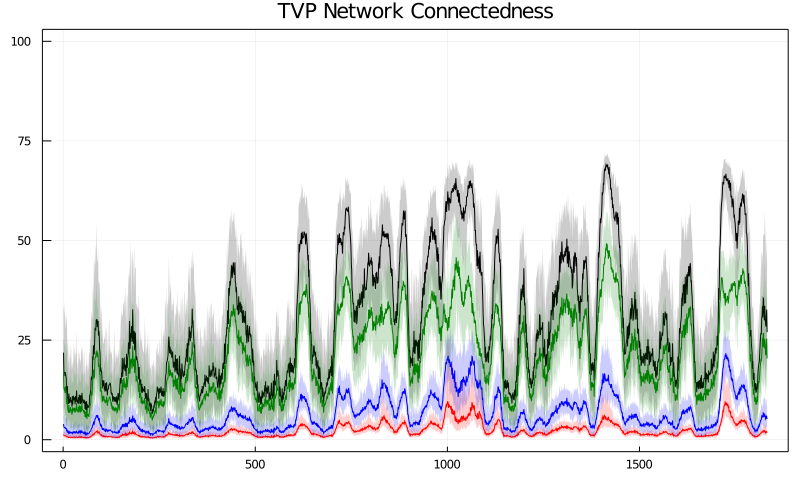

In [13]:
plot(Chorizon[1,:],ribbon=(Chorizon[1,:]-CIhorizon1[1,:],CIhorizon2[1,:]-Chorizon[1,:]),fillalpha=0.2,color=["black" "grey" "grey"],legend=false,ylim=[0,100],framestyle = :box,
    size=(800,480),title="TVP Network Connectedness")
plot!(Chorizon[2,:],ribbon=(Chorizon[2,:]-CIhorizon1[2,:],CIhorizon2[2,:]-Chorizon[2,:]),fillalpha=0.2,color=["red" "red" "red"])
plot!(Chorizon[3,:],ribbon=(Chorizon[3,:]-CIhorizon1[3,:],CIhorizon2[3,:]-Chorizon[3,:]),fillalpha=0.2,color=["blue" "blue" "blue"])
plot!(Chorizon[4,:],ribbon=(Chorizon[4,:]-CIhorizon1[4,:],CIhorizon2[4,:]-Chorizon[4,:]),fillalpha=0.2,color=["green" "green" "green"])

All other horizon specific directional network measures can be obtained analogously chosing the correct row from the output

# Fast multiple cores computation usage

Computations are costly for large systems with large number of variables and simulations consider the use of multiple cores using following package

````julia
Pkg.add("Distributed")
````

Note that in the paper we estimate system of 496 stocks that required several days of multiple server time, hence it is useful to adapt function to the needs of a specific case. For example you can consider saving the results to files as in following example which distributes the core of  the function

````julia
C,CI1,CI2 = DynNet(data,horizon1,horizon2,L,H,W,Nsim,corr)
````

to multiple cores. The computation can be distributed to multiple cores simply, here is an example running on 48 core server

In [ ]:
using Distributed
addprocs(48);

In [ ]:
@everywhere using CSV
@everywhere using DataFrames
@everywhere using Distributions
@everywhere using LinearAlgebra
@everywhere using Statistics

In [ ]:
# load main functions
@everywhere include("DynamicNets_functions.jl");

@everywhere data = CSV.read("exampledata.txt", DataFrame, header=false)
@everywhere data = convert(Matrix{Float64}, data[:,1:9]);
@everywhere data = log.(sqrt.(data));

In [ ]:
@everywhere Nsim = 96

@everywhere shrinkage = 0.05
@everywhere L = 2

@everywhere T, N = size(data)
@everywhere K = N * L + 1

@everywhere X = zeros(Float64, T - L, K-1)
@everywhere for i in 1:L
	temp = lag0(data, i)
    X[:, (1 + N*(i-1) : i*N)] = temp[(1+L:T), :]
end
@everywhere y = data[(1+L):T, :]
@everywhere T = T - L
@everywhere X = [ones(Float64, T, 1) X]

@everywhere K = N * L + 1

@everywhere SI, PI, a, RI = MinnNWprior(data, T, N, L, shrinkage)
@everywhere weights1 = convert.(Float64, normker(T, 8))
@everywhere priorprec0 = convert.(Float64, inv(PI)) 

for it in 1:T

	out = hcat(pmap(i -> f_all(it, i,5,20, T, N, L, weights1, priorprec0, X, y, SI, PI, a, RI, false), 1:Nsim)...);
    
    xmed = [quantile(out[i,:],0.5) for i=1:size(out)[1]]
	xci1 = [quantile(out[i,:],0.025) for i=1:size(out)[1]]
    xci2 = [quantile(out[i,:],0.975) for i=1:size(out)[1]]

	CSV.write("results_time_$it.csv", DataFrame([xmed xci1 xci2]))

end